<a href="https://colab.research.google.com/github/RayyanFv/diabetic-retinopathy-classification/blob/main/colored_diabetic_retinopathy_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data

 98% 234M/238M [00:01<00:00, 140MB/s]
100% 238M/238M [00:01<00:00, 127MB/s]


In [6]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
import zipfile

In [7]:
dataset_zip = zipfile.ZipFile('diabetic-retinopathy-224x224-2019-data.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

In [8]:
df = pd.read_csv(r'/content/train.csv')

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,type
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferate_DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No_DR
4,005b95c28852,0,No_DR


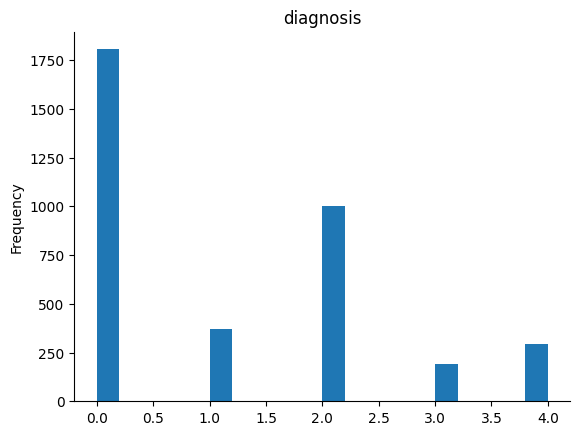

In [9]:
# @title diagnosis

from matplotlib import pyplot as plt
df['diagnosis'].plot(kind='hist', bins=20, title='diagnosis')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [11]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [12]:
# Copy images to respective working directory
src_dir = r'/content/colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    type_diagnosis = row['type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, type_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    type_diagnosis = row['type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, type_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    type_diagnosis = row['type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, type_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [13]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [14]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_batches, epochs=30, validation_data=val_batches)


Epoch 1/30
81/81 [==============================] - 97s 1s/step - loss: 1.2133 - accuracy: 0.5558 - val_loss: 1.6521 - val_accuracy: 0.1673
Epoch 2/30
81/81 [==============================] - 93s 1s/step - loss: 0.8857 - accuracy: 0.6729 - val_loss: 1.6353 - val_accuracy: 0.2200
Epoch 3/30
81/81 [==============================] - 87s 1s/step - loss: 0.8108 - accuracy: 0.7073 - val_loss: 1.4136 - val_accuracy: 0.3455
Epoch 4/30
81/81 [==============================] - 89s 1s/step - loss: 0.7893 - accuracy: 0.7116 - val_loss: 1.1862 - val_accuracy: 0.5873
Epoch 5/30
81/81 [==============================] - 96s 1s/step - loss: 0.7531 - accuracy: 0.7252 - val_loss: 0.9979 - val_accuracy: 0.6836
Epoch 6/30
81/81 [==============================] - 89s 1s/step - loss: 0.7331 - accuracy: 0.7346 - val_loss: 0.8572 - val_accuracy: 0.7036
Epoch 7/30
81/81 [==============================] - 89s 1s/step - loss: 0.7143 - accuracy: 0.7342 - val_loss: 0.7853 - val_accuracy: 0.7091
Epoch 8/30
81/81 [==

In [15]:
model.save('64x3-CNN.model')

In [16]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Accuracy: ", acc)
print("Loss: ", loss)

<ipython-input-16-6366e5e0d246>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 7s 354ms/step - loss: 0.7670 - accuracy: 0.7018
Accuracy:  0.7018181681632996
Loss:  0.7669858336448669


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files

In [18]:
def predict_class(path, diagnosis_dict):
    img = cv2.imread(path)
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224, 224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict = new_model.predict(np.array([image]))
    predicted_class = np.argmax(predict)
    print('Predicted class:', diagnosis_dict[predicted_class])

# Define your diagnosis dictionary
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

In [ ]:
# Upload an image for classification
uploaded = files.upload()

for filename in uploaded.keys():
    print('Predicting class for:', filename)
    predict_class(filename, diagnosis_dict)